Mean of the simulated contract price 0.3576341214712047
90% of the simulated contract price interval [0.31848497 0.39587473]


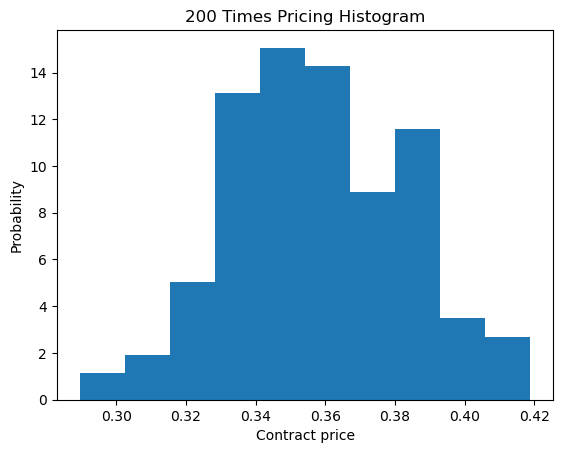

In [32]:
# hullWhite_Pricing.py

# Required Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import QuantLib as ql

# Function for Pricing
def contract_price_simulation():

    # Model Parameters
    volatility = 0.02
    mean_reversion = 0.05
    maturity = 3
    steps_per_year = 252
    steps_total = maturity * steps_per_year
    forward_rate = 0.0021
    day_counter = ql.Thirty360(ql.Thirty360.USA)
    evaluation_date = ql.Date(30, 12, 2022)
    ql.Settings.instance().evaluationDate = evaluation_date

    # Building the yield curve
    forward_rate_quote = ql.QuoteHandle(ql.SimpleQuote(forward_rate))
    yield_curve = ql.FlatForward(evaluation_date, forward_rate_quote, day_counter)
    yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)

    # Hull-White process and path generator
    hw_process = ql.HullWhiteProcess(yield_curve_handle, mean_reversion, volatility)
    uniform_generator = ql.UniformRandomGenerator()
    sequence_generator = ql.UniformRandomSequenceGenerator(steps_total, uniform_generator)
    gaussian_sequence_generator = ql.GaussianRandomSequenceGenerator(sequence_generator)
    path_generator = ql.GaussianPathGenerator(hw_process, maturity, steps_total, gaussian_sequence_generator, False)

    # Function to generate the paths
    def generate_paths(num_simulations):
        path_array = np.zeros((num_simulations, steps_total + 1))
        for i in range(num_simulations):
            sample_path = path_generator.next().value()
            path_array[i, :] = np.array([sample_path[j] for j in range(len(sample_path))])
        return np.array([sample_path.time(j) for j in range(len(sample_path))]), path_array

    # Number of simulations
    num_simulations = 1000

    # Generate paths and convert to DataFrame
    time_points, sim_paths = generate_paths(num_simulations)
    rate_paths = pd.DataFrame(sim_paths).T

    # Pricing calculations
    dt = 1 / steps_per_year
    prices = np.empty_like(rate_paths)

    # Function to price based on HW model
    def price_hw_model(T, t, forward_rate, rates):
        tau = T - t
        B = (1 - np.exp(-mean_reversion * tau)) / mean_reversion
        A = np.exp(-forward_rate * tau + B * forward_rate - volatility ** 2 / (4 * mean_reversion ** 3) * (np.exp(-mean_reversion * T) - np.exp(-mean_reversion * t)) * (np.exp(2 * mean_reversion * t) - 1))
        return A * np.exp(-rates * B)

    # Prices and Libor equity calculations
    price_90_days = price_hw_model(maturity, maturity - 90 * dt, forward_rate, rate_paths.values[steps_total - 90])
    average_price = np.mean(price_90_days)

    # Libor equity pricing
    libor_derivative = -(price_90_days - 1) / price_90_days
    price_0 = price_hw_model(maturity, 0, forward_rate, rate_paths.values[0])
    price_derivative = price_hw_model(maturity - 90 * dt, 0, forward_rate, rate_paths.values[0])
    libor_0 = -(price_0 - price_derivative) / (price_0 * 90 * dt)

    # Quanto equity pricing
    stock_price = 26094.50
    maturity_years = 3  
    risk_free_rate = -0.001   
    dividend_rate = 0.015  
    stock_volatility = 0.1374056296970254
    exchange_rate_volatility = 0.051993926383636846
    correlation = 0.7745361023076186

    # Generate geometric paths
    def generate_geometric_paths(initial_price, maturity, risk_free_rate, dividend_rate, stock_volatility, exchange_rate_volatility, correlation, steps_total, num_simulations):
        dt = maturity / steps_total
        log_stock_prices = np.log(initial_price) + np.cumsum(((risk_free_rate - dividend_rate - stock_volatility * exchange_rate_volatility * correlation - stock_volatility ** 2 / 2) * dt + stock_volatility * np.sqrt(dt) * np.random.normal(size=(steps_total, num_simulations))), axis=0)
        return np.exp(log_stock_prices)

    # Generate paths
    sim_paths_stock = generate_geometric_paths(stock_price, maturity_years, risk_free_rate, dividend_rate, stock_volatility, exchange_rate_volatility, correlation, steps_total, num_simulations)
    stock_price_at_maturity = sim_paths_stock[-1]

    # Strike price
    strike_price = 1

    # Calculate the payoff
    payoff = (strike_price - libor_derivative / libor_0) * (stock_price_at_maturity / stock_price - strike_price)
    payoff = np.maximum(payoff, 0)   # Apply the payoff condition

    # Return the average contract price
    return np.mean(payoff)

# Simulation and results
simulated_contract_prices = [contract_price_simulation() for _ in range(200)]
print("Mean of the simulated contract price", np.mean(simulated_contract_prices))
print("90% of the simulated contract price interval", np.percentile(simulated_contract_prices, [5, 95]))

# Plot the histogram
plt.hist(simulated_contract_prices, density=True, bins=10)
plt.title("200 Times Pricing Histogram")
plt.ylabel('Probability')
plt.xlabel('Contract price')
plt.savefig("image/Hull_White_simulation_histogram.pdf")

